# Introduction

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)


import pandas as pd 


drive.mount(ROOT)
%cd '{REPO_PATH}'

In [1]:
repo_name = 'politicalbias'
GIT_REPO = 'https://github.com/thekhan314/politicalbias.git'


from os.path import join
from google.colab import drive

BASE = 'My Drive/Colab Notebooks/'
ROOT = '/content/drive/'
PROJECT_PATH = join(ROOT,BASE)
REPO_PATH = join(PROJECT_PATH,repo_name)

drive.mount(ROOT)
%cd '{REPO_PATH}'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks/politicalbias


# Imports

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import json

import random
random.seed(11)
import math
from matplotlib import cycler
import matplotlib.pyplot as plt
#import textdistance
import matplotlib as mpl


import os
import glob

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

import nltk
from nltk import word_tokenize
nltk.download('punkt')
from sklearn.feature_extraction import text as sk_text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
 
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## IBC Data

Pulled from 
Columns:


In [3]:
df_ibc = pd.read_csv('data/IBC_data_2_labels.csv')
df_ibc.info()
#df_ibc['Label'].hist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4326 entries, 0 to 4325
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  4326 non-null   object
 1   Label     4326 non-null   object
dtypes: object(2)
memory usage: 67.7+ KB


## Political Bias (Antaripa)

In [4]:
df_ant = pd.read_csv('data/political_bias_summarized_binary_levels.csv')
df_ant.head()
df_ant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9458 entries, 0 to 9457
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   article_text        9458 non-null   object
 1   word_count          9458 non-null   int64 
 2   summary             9447 non-null   object
 3   summary_word_count  9458 non-null   int64 
 4   label               9458 non-null   object
dtypes: int64(2), object(3)
memory usage: 369.6+ KB


In [5]:
# Fit a baseline model, pull weights, cluster somehow and find most common hate words

# Adfontes

https://medium.com/analytics-vidhya/mlforsocial-predicting-media-bias-8e94d03befb5

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3707 entries, 0 to 3706
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   article_title  3707 non-null   object 
 1   article_bias   3707 non-null   float64
 2   reliability    3707 non-null   float64
 3   article_url    3707 non-null   object 
 4   article_text   3707 non-null   object 
 5   length         3707 non-null   int64  
 6   bias           3707 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 202.9+ KB


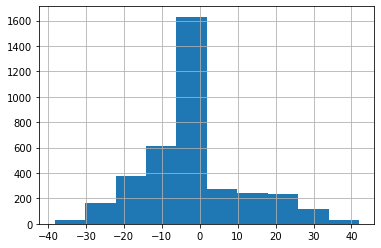

In [6]:


df_adf = pd.read_csv('data/adfontes_political_bias.csv')
df_adf.head()
df_adf.info()
df_adf.describe()
df_adf['article_bias'].hist()

In [7]:
df_left = df_adf[df_adf['article_bias'] < -13]
df_right = df_adf[df_adf['article_bias'] > 10]

df_left.info()
df_right.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 617 entries, 137 to 3706
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   article_title  617 non-null    object 
 1   article_bias   617 non-null    float64
 2   reliability    617 non-null    float64
 3   article_url    617 non-null    object 
 4   article_text   617 non-null    object 
 5   length         617 non-null    int64  
 6   bias           617 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 38.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 620 entries, 42 to 3692
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   article_title  620 non-null    object 
 1   article_bias   620 non-null    float64
 2   reliability    620 non-null    float64
 3   article_url    620 non-null    object 
 4   article_text   620 non-null    object 
 5   length         

In [8]:
def word_counts(df_main,col, stopwords='english',show_chart = True):
    countvec = CountVectorizer(stop_words=stopwords)
    df_wordcounts= countvec.fit_transform(df_main[col])

    words = countvec.get_feature_names()
    sums = df_wordcounts.toarray().sum(axis=0)
    count_dict = dict(zip(words,sums))

    count_series = pd.Series(count_dict)
    count_series.sort_values(ascending = False,inplace=True)

    if show_chart == True:
        plot_wordcounts(count_series)

    return count_series

def plot_wordcounts(series,cap = 30):
    top_30 = series.head(30)

    fig,ax = plt.subplots(figsize=(30,20))

    ax.tick_params(
        axis='x', 
        labelrotation=35,
        length=10,
        labelsize= 26
        )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.grid(False)

    ax.bar(list(top_30.index),top_30)

    fig.tight_layout()

    fig.show()

    

26562

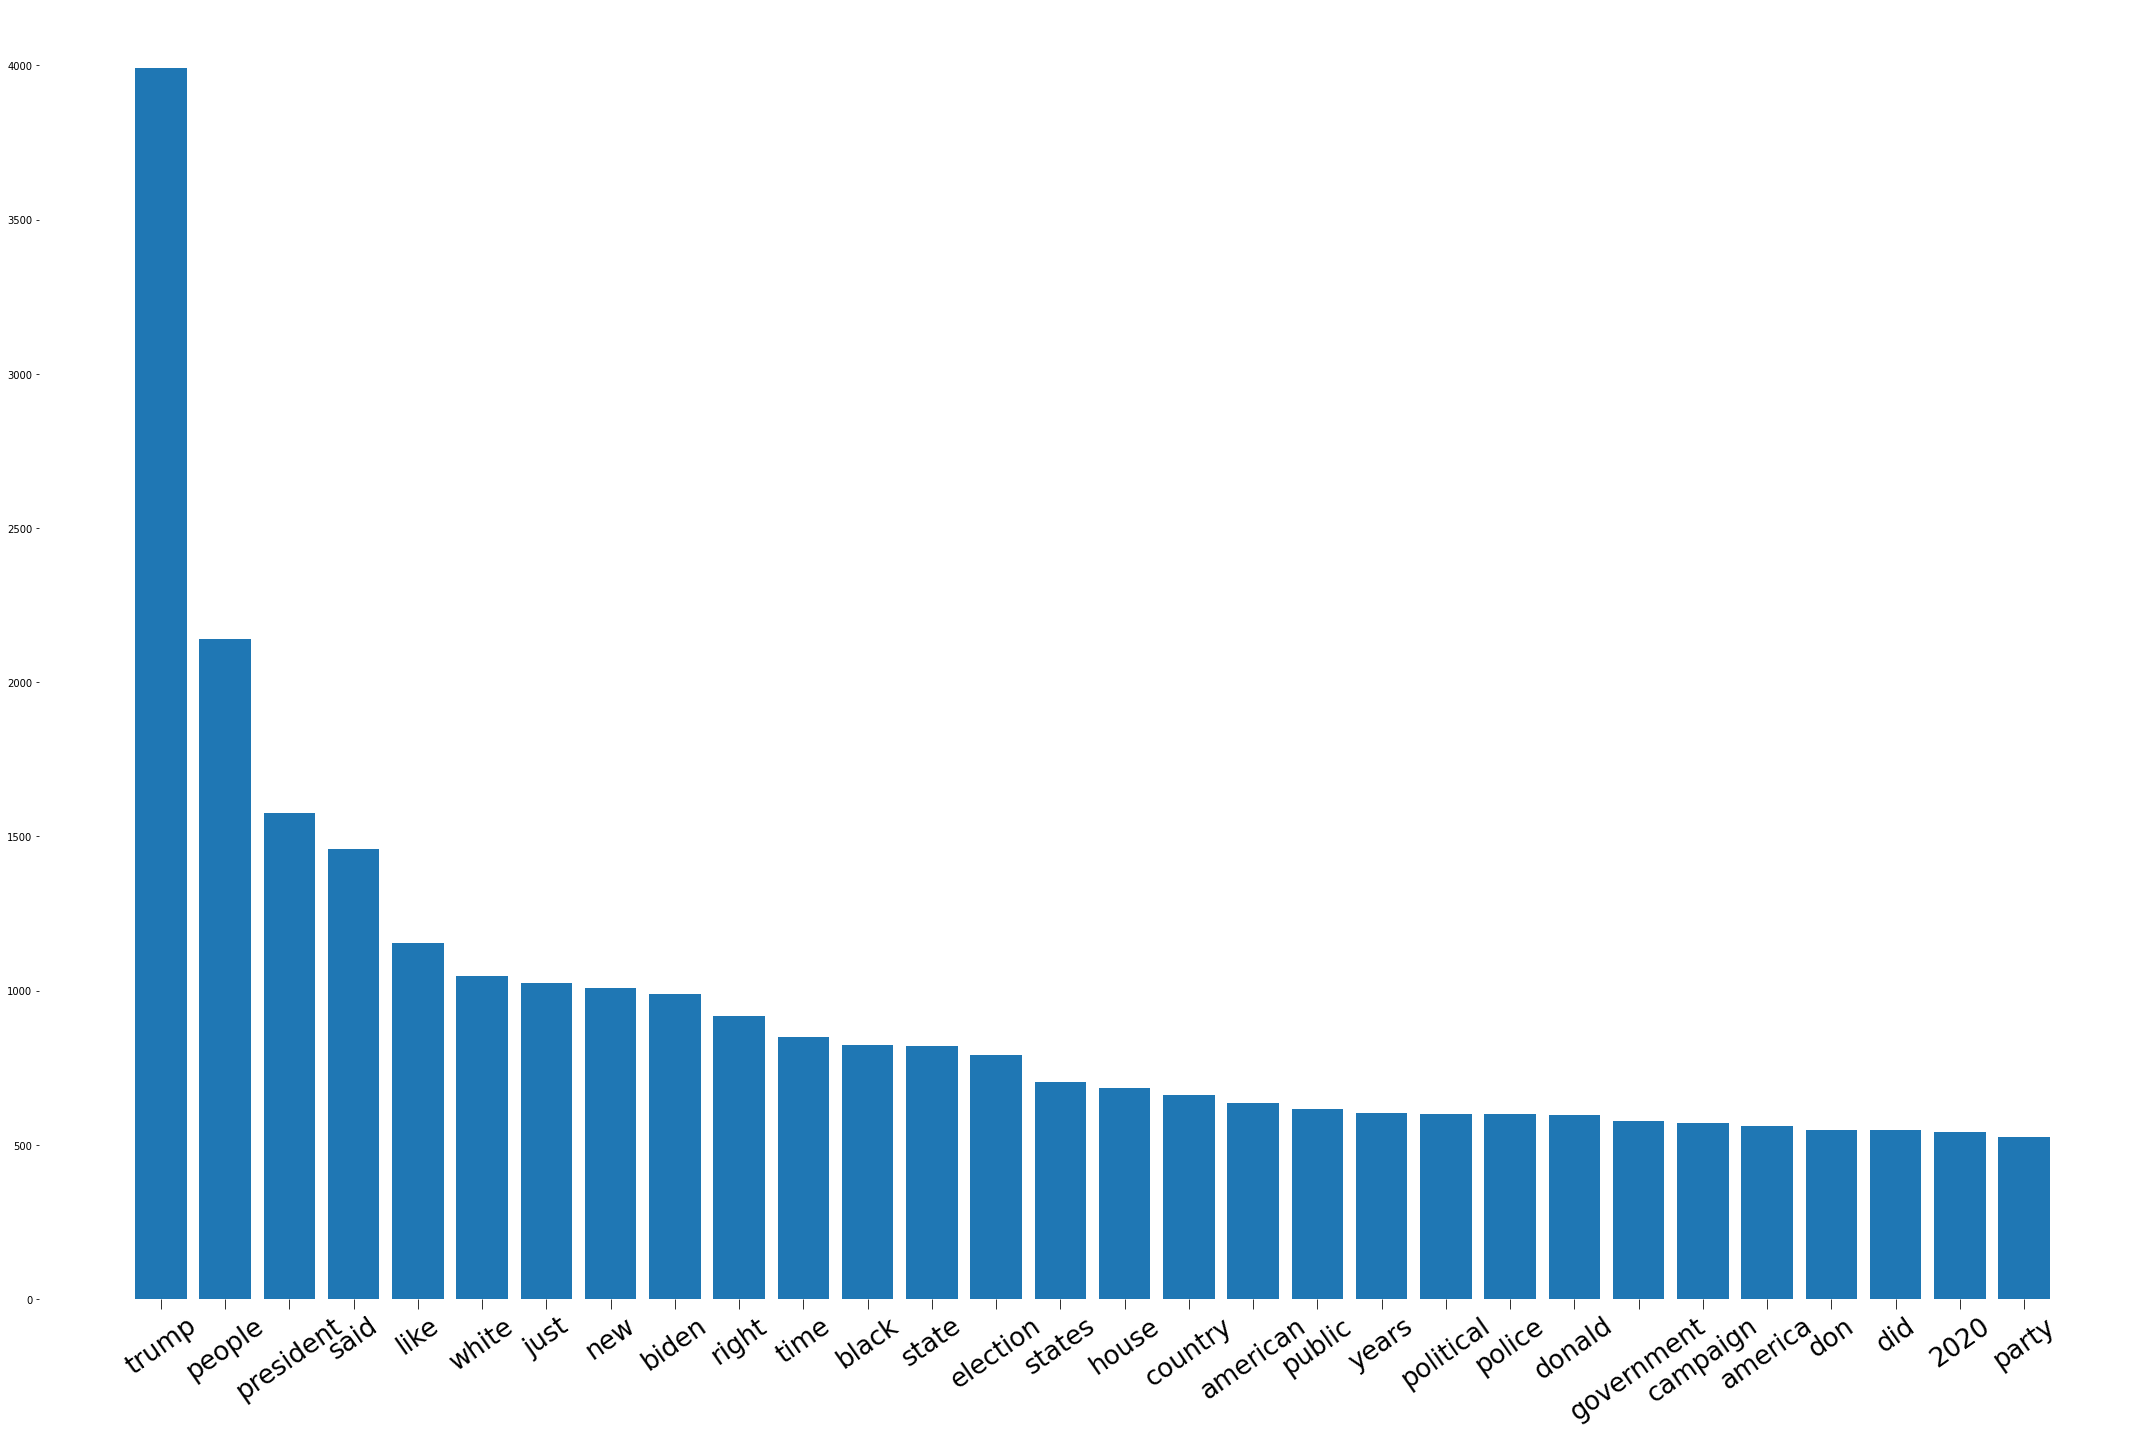

In [9]:
left_counts = word_counts(df_left,'article_text')
len(left_counts)

24466

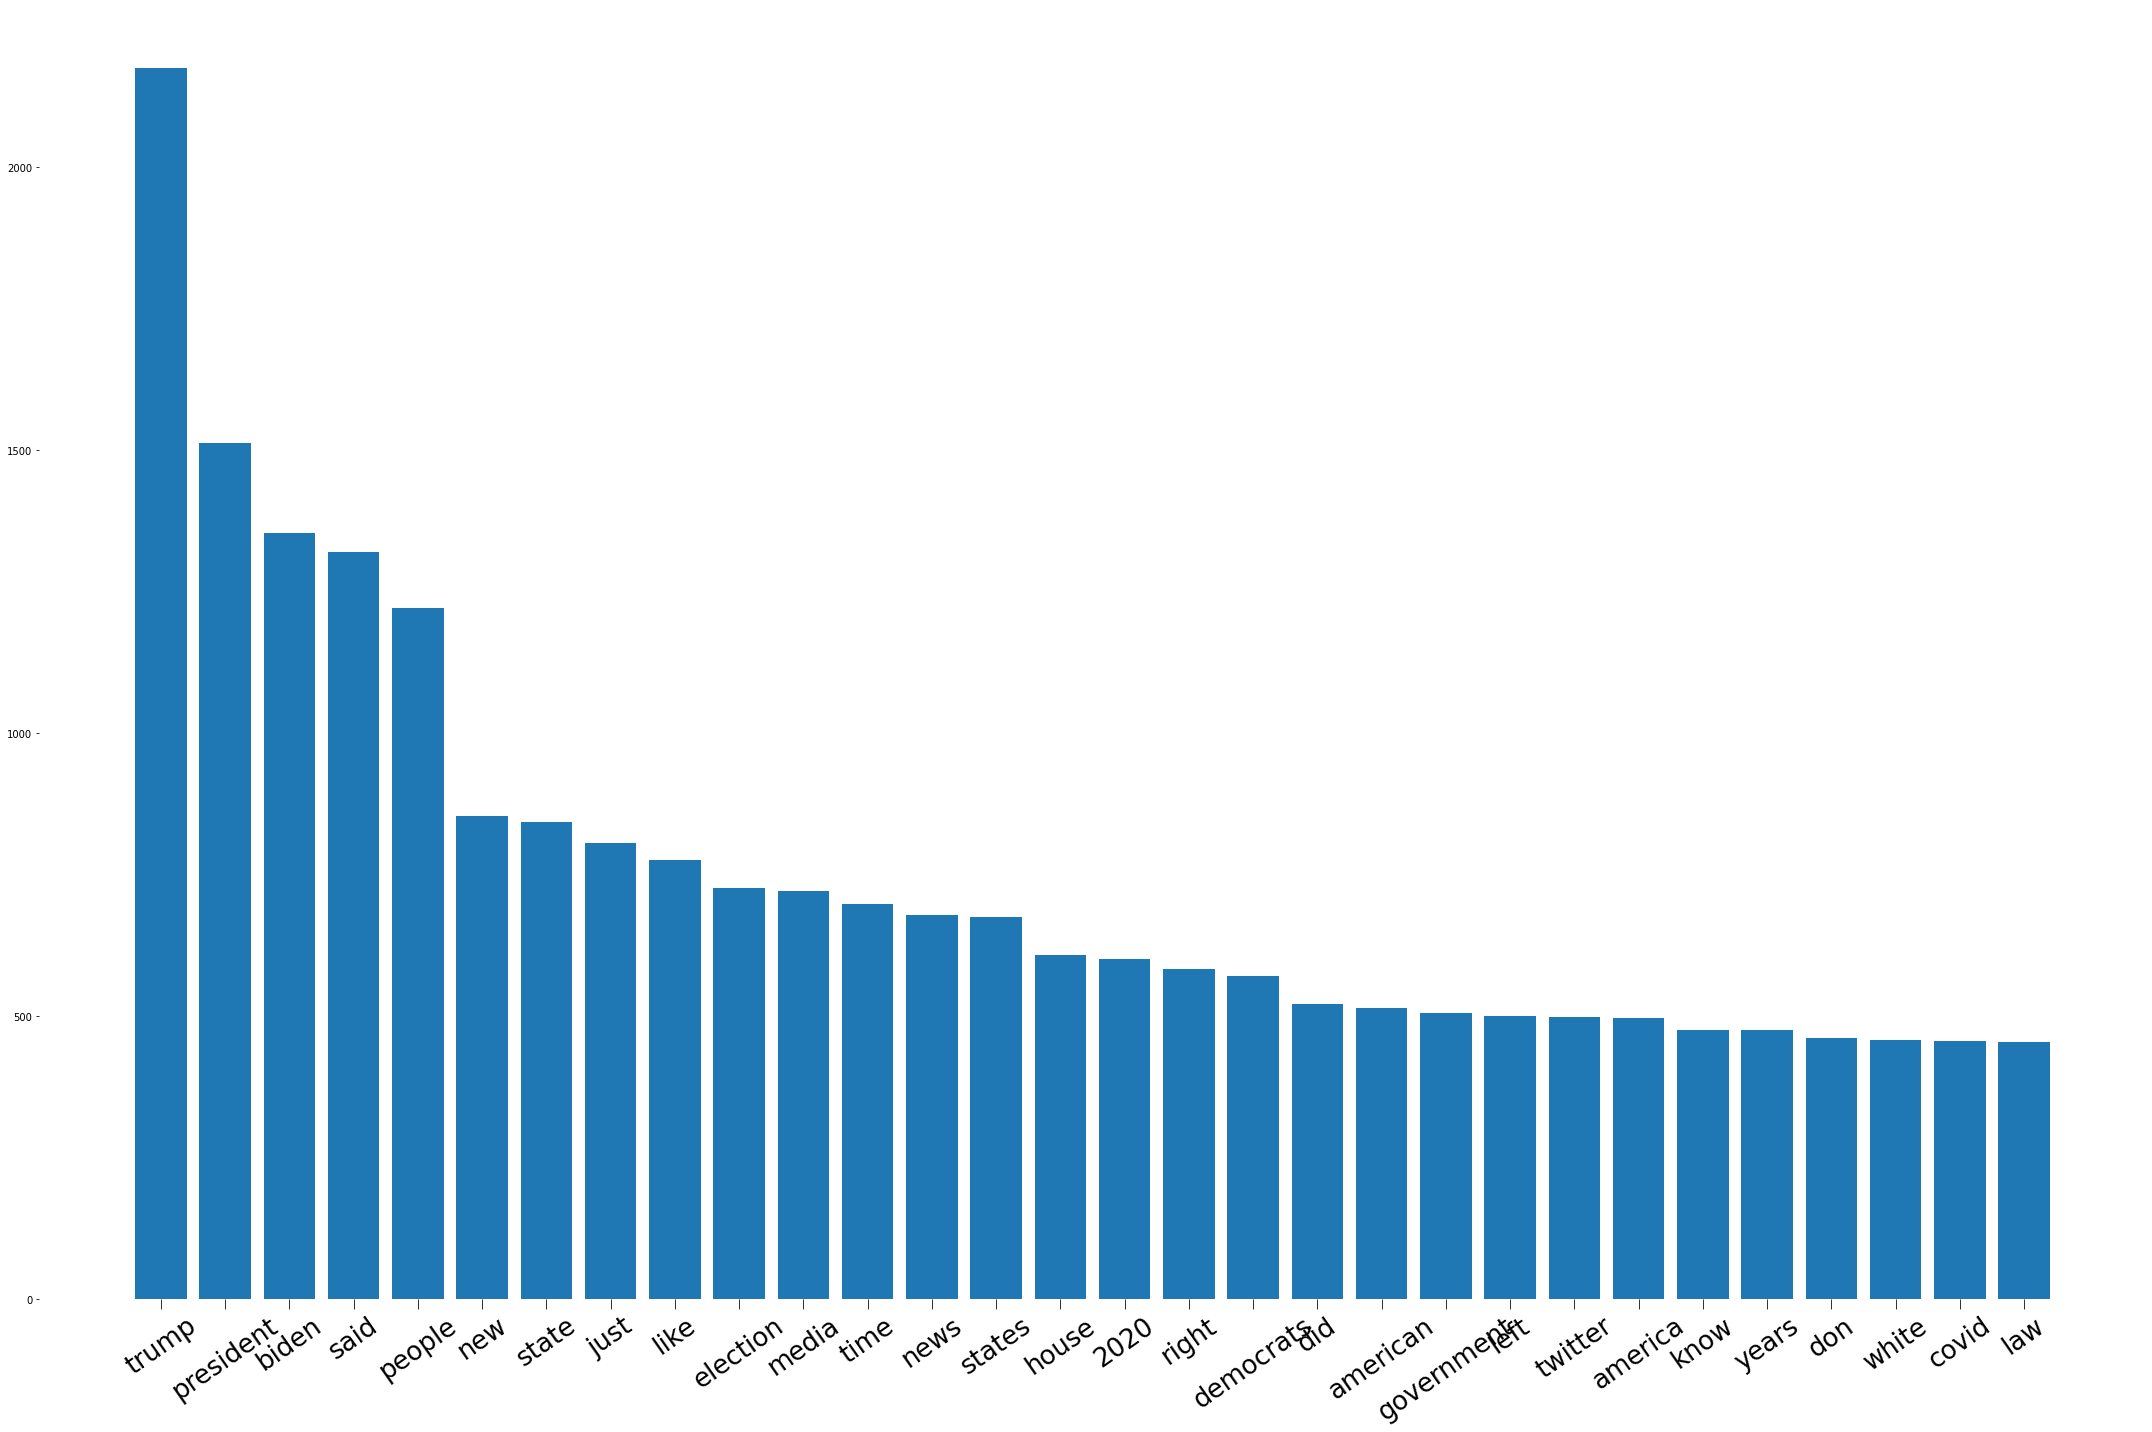

In [10]:
right_counts = word_counts(df_right,'article_text')
len(right_counts)

In [11]:

# find least common words
# predict bias - get weights

In [12]:
def compare_vocabs(seta,setb):
    left_words = set(seta.index)
    right_words = set(setb.index)

    left_notin_right = list(left_words - right_words)
    sr_right_notin_left = seta[left_notin_right]
    sr_right_notin_left.sort_values(ascending=False,inplace=True)
    plot_wordcounts(sr_right_notin_left)

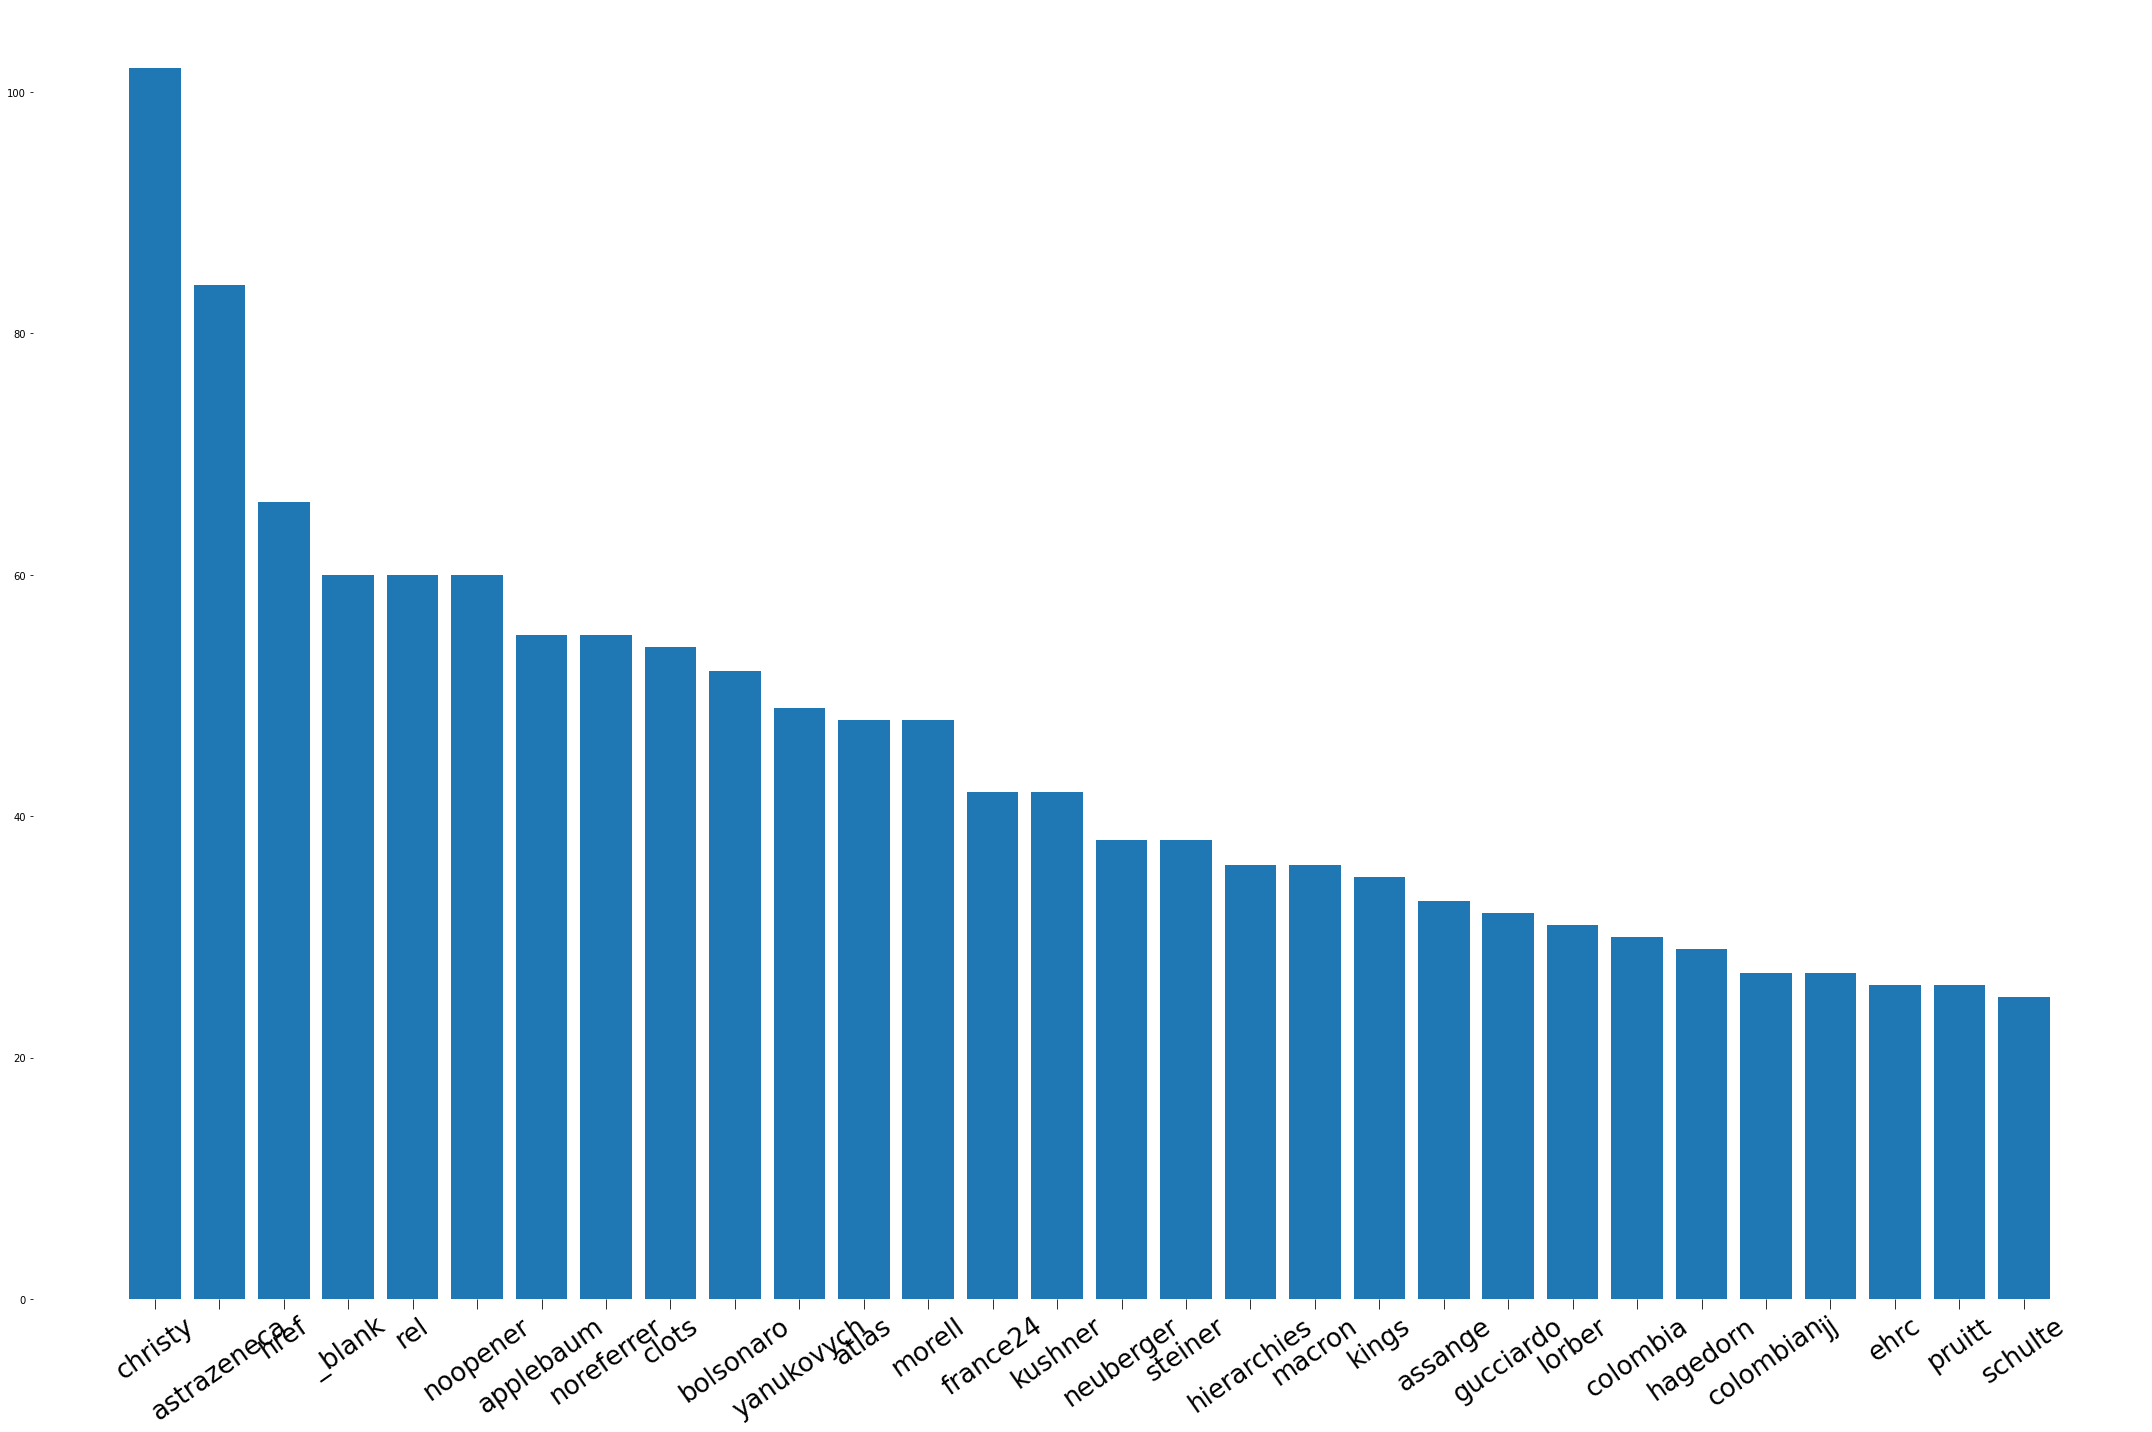

In [13]:
compare_vocabs(left_counts,right_counts)

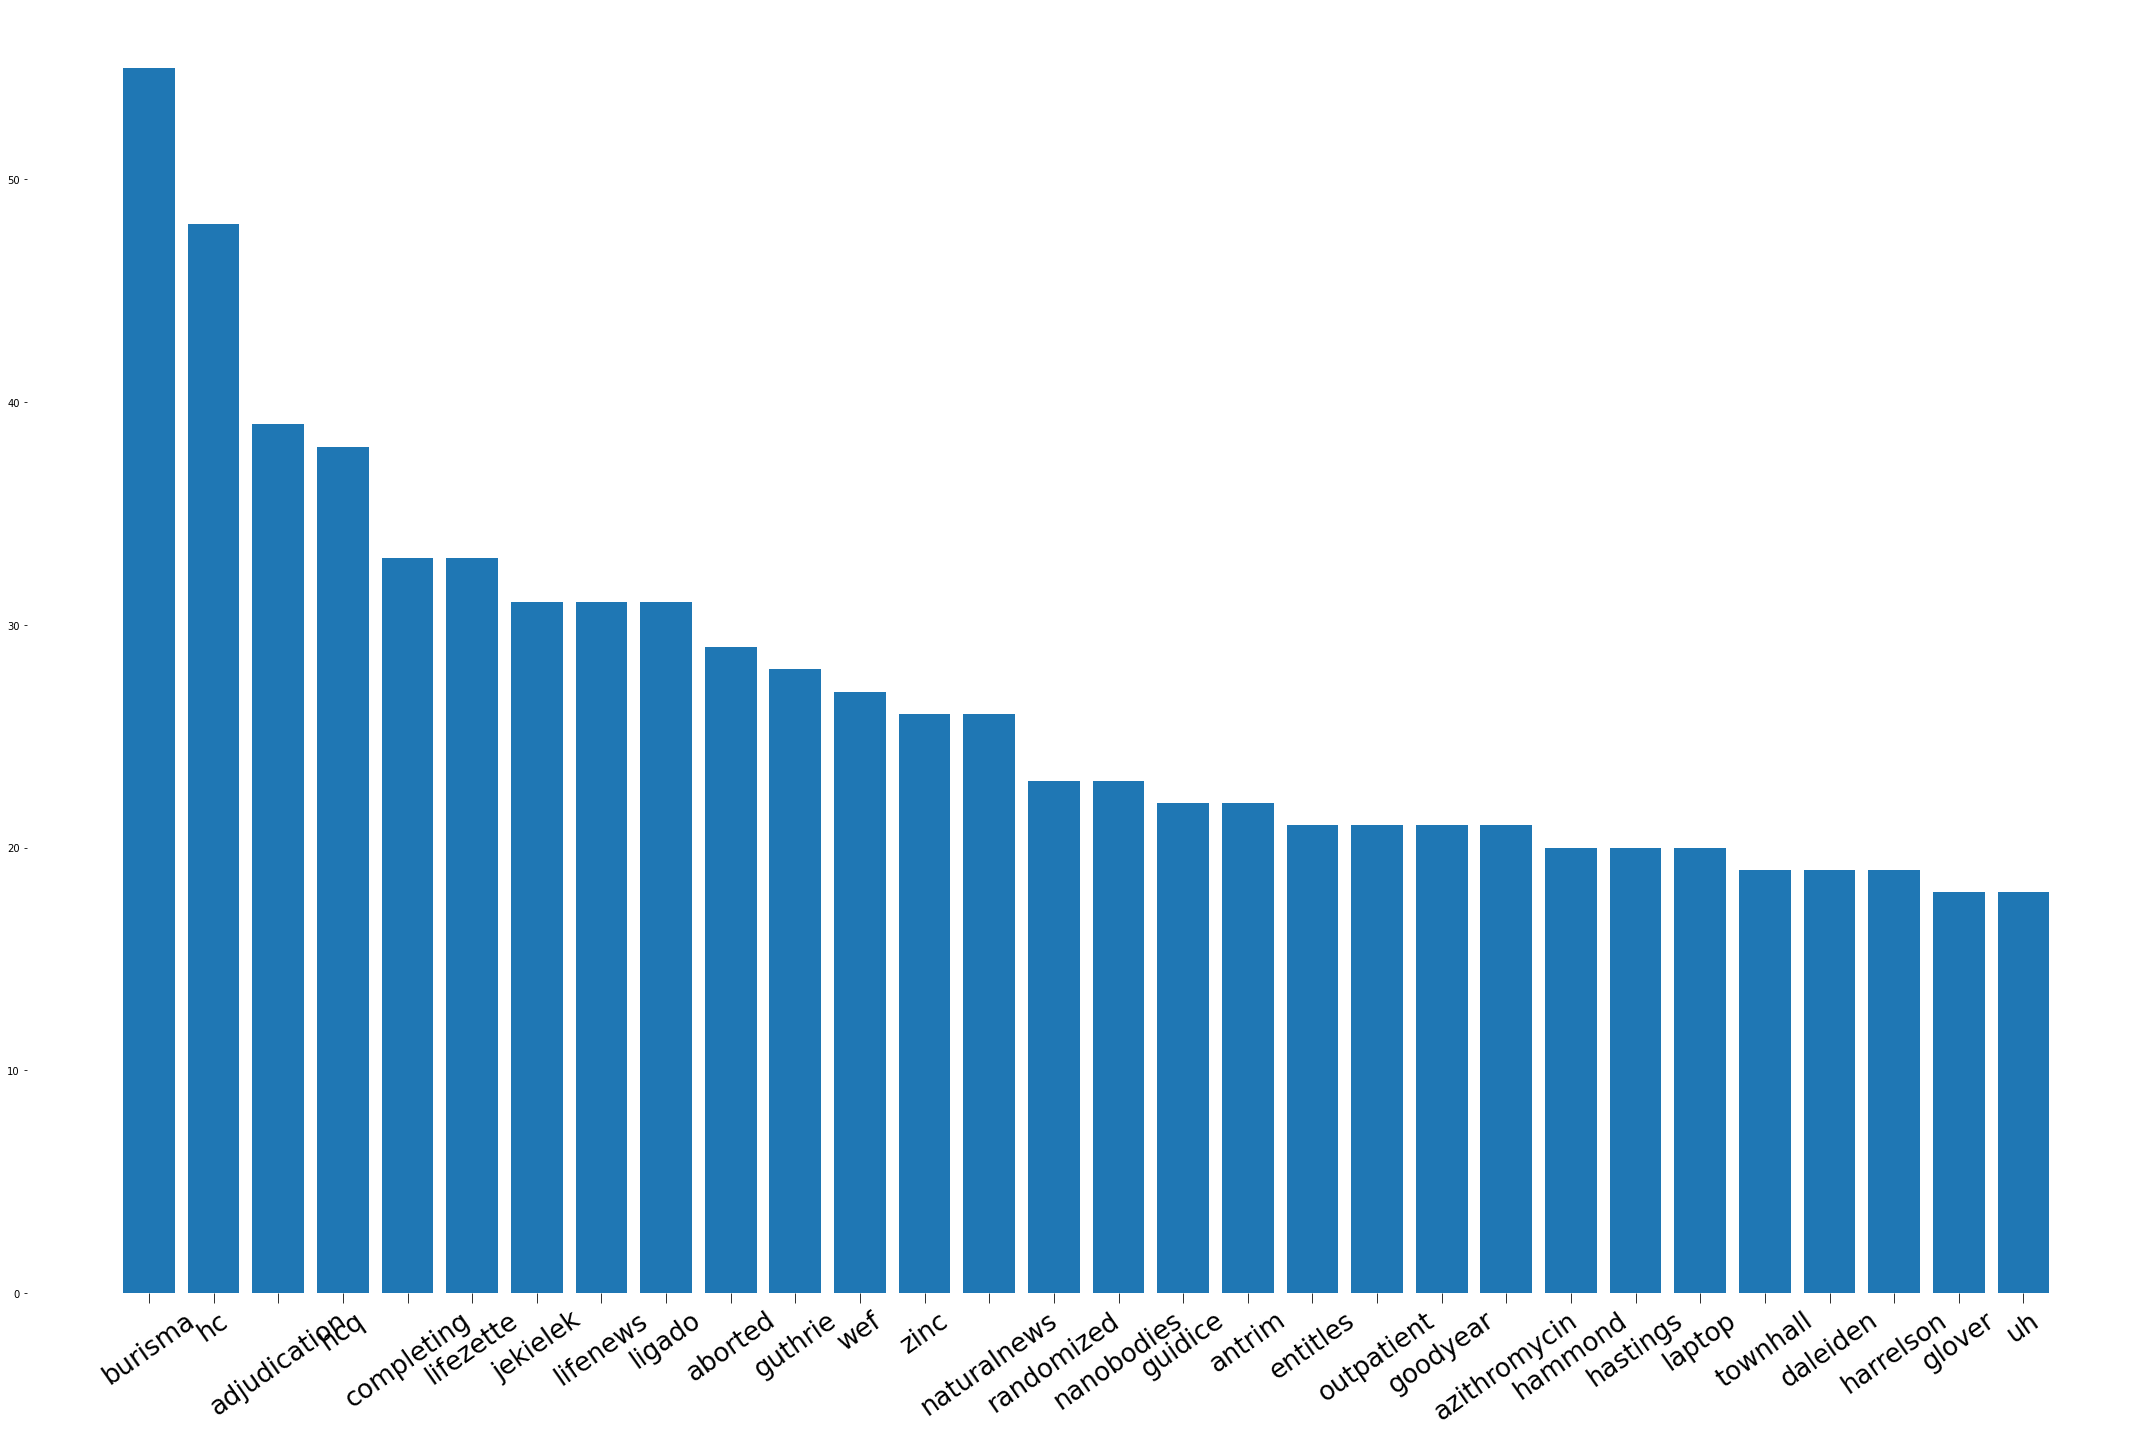

In [14]:
compare_vocabs(right_counts,left_counts)

In [15]:
#more context around word occurences? a function that pulls context 
#LDA? 